In [1]:
!pip install ../

Processing /notebooks/diy-stable-diffusion
  Preparing metadata (setup.py) ... done
  Created wheel for diy-stable-diffusion: filename=diy_stable_diffusion-0.0.1-py3-none-any.whl size=8344 sha256=7cc79a550920d130c8e3cb86a272363eb7e800f983969b04e288b18bc50766d7
  Stored in directory: /root/.cache/pip/wheels/44/ea/57/ffb31f1d8d8df22bd19518b55a4093efb82519b26708c5fb7e
Successfully built diy-stable-diffusion
  Attempting uninstall: diy-stable-diffusion
    Found existing installation: diy-stable-diffusion 0.0.1
    Uninstalling diy-stable-diffusion-0.0.1:
      Successfully uninstalled diy-stable-diffusion-0.0.1


In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.training import *
from diy_stable_diffusion.conv import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

In [4]:
x,y = 'image', 'label'
name='fashion_mnist'
ds_dict= load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
@inplace
def transform_im(batch):
    batch[x] = [TF.to_tensor(o) for o in batch[x]]

In [8]:
bs = 256
tensor_ds = ds_dict.with_transform(transform_im)

<AxesSubplot:>

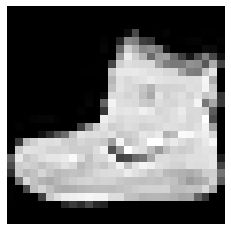

In [9]:
ds_train= tensor_ds['train']
im=ds_train[0]['image']
show_image(im)

In [10]:
collate_fn=collate_dict(ds_train)

In [11]:
collate_dict??

Signature: collate_dict(ds)
Docstring: <no docstring>
Source:   
def collate_dict(ds):
    getter = itemgetter(*ds.features)
    def _f(b):
        return getter(default_collate(b))
    return _f
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/datasets.py
Type:      function


In [15]:
def collate_(batch):
    return to_device(collate_fn(batch))

def data_loaders(ds_dict, bs, **kwargs):
    return {k:DataLoader(v, bs, **kwargs) for k, v in ds_dict.items()}

In [35]:
dls = data_loaders(tensor_ds, bs, collate_fn=collate_)
train_dl = dls['train']
valid_dl = dls['test']

xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [21]:
labels=ds_train.features['label'].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [24]:
l = [90, 91, 92]
g=itemgetter(0,2,2)
g(l)

(90, 92, 92)

In [29]:
ybs=yb[:16]
lbl_getter = itemgetter(*ybs)
titles=lbl_getter(labels)
titles,ybs,[labels[i] for i in ybs]

(('Ankle boot',
  'T - shirt / top',
  'T - shirt / top',
  'Dress',
  'T - shirt / top',
  'Pullover',
  'Sneaker',
  'Pullover',
  'Sandal',
  'Sandal',
  'T - shirt / top',
  'Ankle boot',
  'Sandal',
  'Sandal',
  'Sneaker',
  'Ankle boot'),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9], device='cuda:0'),
 ['Ankle boot',
  'T - shirt / top',
  'T - shirt / top',
  'Dress',
  'T - shirt / top',
  'Pullover',
  'Sneaker',
  'Pullover',
  'Sandal',
  'Sandal',
  'T - shirt / top',
  'Ankle boot',
  'Sandal',
  'Sandal',
  'Sneaker',
  'Ankle boot'])

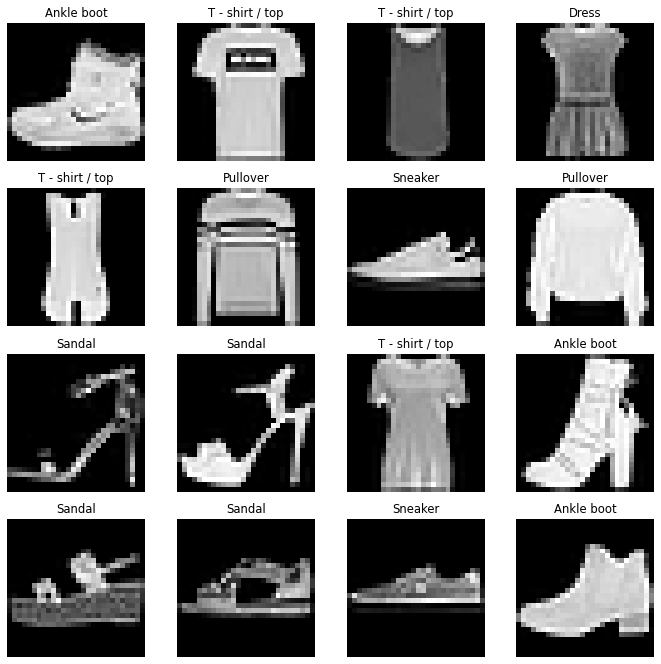

In [30]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], titles=titles)

In [31]:
from torch import optim

bs = 256
lr = 0.4

In [32]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten())
cnn = cnn.to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
fit(5, cnn, F.cross_entropy, opt, train_dl, valid_dl)

epoch: 0, val loss: 0.659441, val accuracy: 0.754400
epoch: 1, val loss: 0.564226, val accuracy: 0.799600


In [38]:
fit(1, cnn, F.cross_entropy, opt, train_dl, valid_dl)

epoch: 0, val loss: 0.441331, val accuracy: 0.841500


In [39]:
ds_dict['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

In [46]:
def deconv(in_channels, out_channels, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=ks, padding=ks//2)
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [52]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        total_loss=0.0
        count=0
        for xb, _ in valid_dl:
            pred=model(xb)
            n=len(xb)
            count += n
            total_loss += loss_func(pred, xb).item() * n
    print(f'epoch: {epoch}\tvalid/loss: {total_loss/count:.3f}')

In [44]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [48]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1, 2),
    conv(2, 4),
    conv(4, 8),
    deconv(8, 4),
    deconv(4, 2),
    deconv(2, 1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()
).to(def_device)

In [53]:
eval(ae, F.mse_loss, valid_dl)

epoch: 0	valid/loss: 0.167


In [55]:
opt=optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, train_dl, valid_dl)

epoch: 0	valid/loss: 0.143
epoch: 1	valid/loss: 0.135
epoch: 2	valid/loss: 0.131
epoch: 3	valid/loss: 0.128
epoch: 4	valid/loss: 0.126


In [56]:
opt=optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, train_dl, valid_dl)

epoch: 0	valid/loss: 0.068
epoch: 1	valid/loss: 0.048
epoch: 2	valid/loss: 0.042
epoch: 3	valid/loss: 0.037
epoch: 4	valid/loss: 0.035


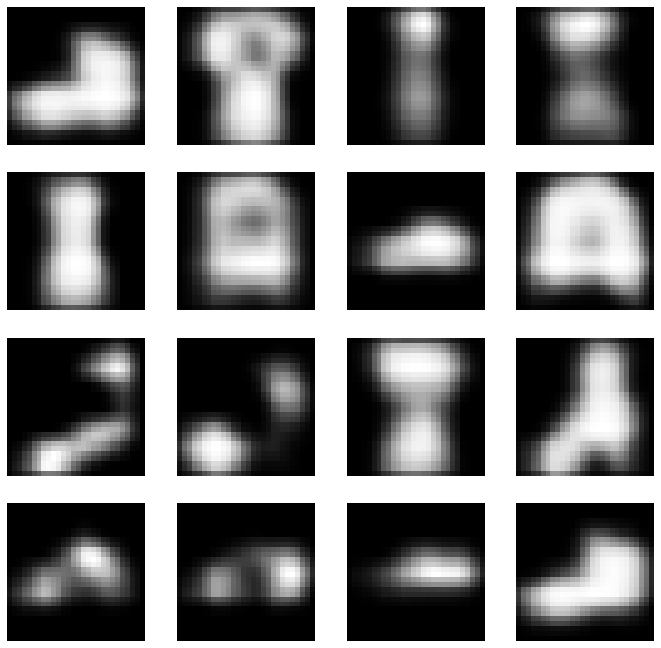

In [57]:
p=ae(xb)
show_images(p[:16].data.cpu())

In [ ]:
opt=optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, train_dl, valid_dl)

epoch: 0	valid/loss: 0.034
epoch: 1	valid/loss: 0.034
epoch: 2	valid/loss: 0.034
epoch: 3	valid/loss: 0.034
epoch: 4	valid/loss: 0.033


epoch: 0	valid/loss: 0.030
epoch: 1	valid/loss: 0.029
epoch: 2	valid/loss: 0.029
epoch: 3	valid/loss: 0.029
epoch: 4	valid/loss: 0.029
epoch: 5	valid/loss: 0.029
epoch: 6	valid/loss: 0.028
epoch: 7	valid/loss: 0.028
epoch: 8	valid/loss: 0.027
epoch: 9	valid/loss: 0.028
epoch: 10	valid/loss: 0.027
epoch: 11	valid/loss: 0.027
epoch: 12	valid/loss: 0.026
epoch: 13	valid/loss: 0.027
epoch: 14	valid/loss: 0.026
epoch: 15	valid/loss: 0.026
epoch: 16	valid/loss: 0.025
epoch: 17	valid/loss: 0.026
epoch: 18	valid/loss: 0.025
epoch: 19	valid/loss: 0.026
epoch: 20	valid/loss: 0.024
epoch: 21	valid/loss: 0.025
epoch: 22	valid/loss: 0.024
epoch: 23	valid/loss: 0.025
epoch: 24	valid/loss: 0.024


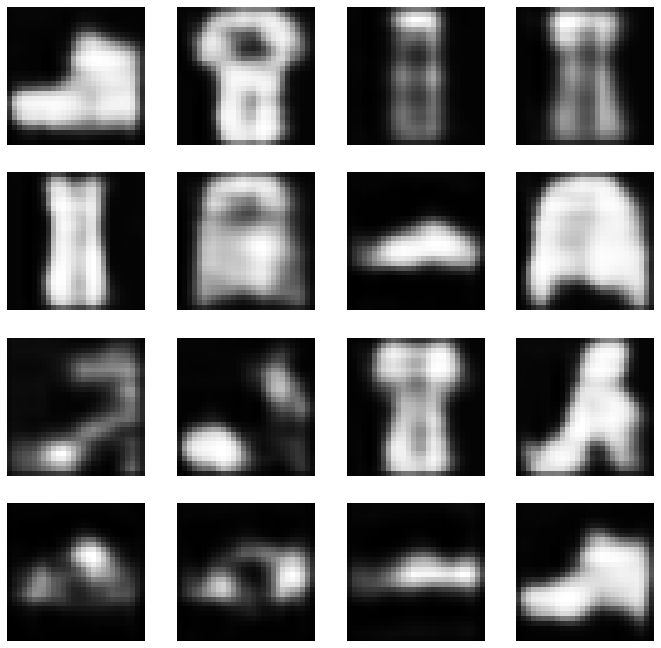

In [63]:
#note: have run this cell now multiple times
opt=optim.SGD(ae.parameters(), lr=0.1)
fit(25, ae, F.mse_loss, opt, train_dl, valid_dl)

p=ae(xb)
show_images(p[:16].data.cpu())

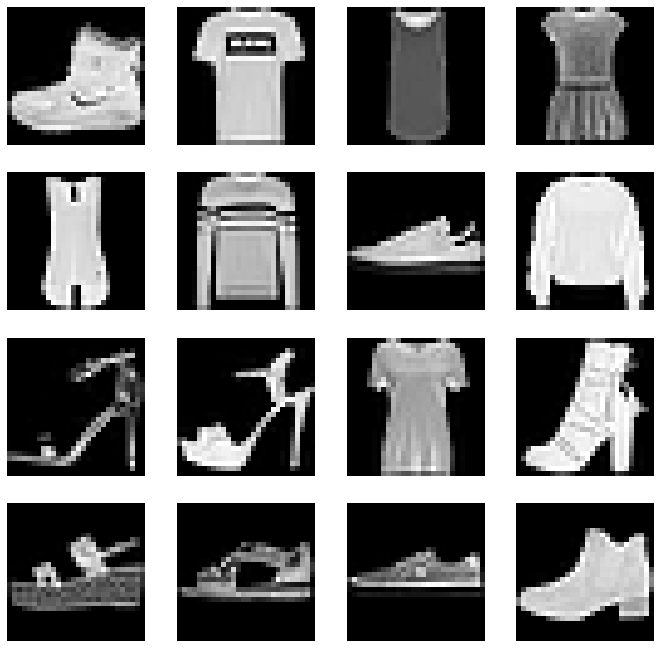

In [58]:
show_images(xb[:16].data.cpu())